# データの可視化
1. 天体の基本的な特性の分布:
- mag_auto (自動等級) のヒストグラムを作成し、天体の明るさの分布を可視化してください。
- area_auto (自動面積) のヒストグラムを作成し、天体のサイズの分布を可視化してください。
- 既知の赤方偏移 z_spec がある天体について、赤方偏移のヒストグラムを作成し、宇宙のどのくらいの距離の天体が観測されているかを確認してください。
2. 異なるフィルター間の関係性 (色-色図):
- 例えば、f115w_flux_aper_1 と f150w_flux_aper_1 のフラックスを使って、色 (f115w - f150w) を計算します。同様に、別のフィルターペア（例: f150w と f200w）でも色を計算します。
- これらの2つの色を軸とした散布図（色-色図）を作成し、天体の分布を調べてください。異なる種類の天体は異なる領域に分布する可能性があります。
3. 天体の空間分布:
- ra (赤経) と dec (赤緯) を用いて、観測された天体の空における分布を散布図で可視化してください。分布に偏りがあるかなどを確認できます。
4. 物理量間の関係性:
- mag_auto (等級) と area_auto (面積) の散布図を作成し、明るい天体と暗い天体のサイズに違いがあるかなどを調べてください。
- 既知の赤方偏移 z_spec がある天体について、z_spec と mag_auto の散布図を作成し、遠い天体ほど暗く見える傾向があるかなどを確認してください。

In [14]:
from torch.utils.data import DataLoader
from custom_dataset import HDF5Dataset

# 特徴量として使用する列名
features = [
    # マグニチュードはフラックスと逆の関係にあるため、暗いオブジェクト（マグニチュードが大きい）ほど、area_auto が小さくなる傾向があるかもしれません。
    'mag_auto',
    'mag_iso',
    # アイソフォタル（等光度）アパーチャによる面積であり、オブジェクトのサイズを測る別の方法です。自動アパーチャによる面積と強い相関があると考えられます。
    'area_iso',
    # Kron 半径は、オブジェクトの光度分布に基づいて定義される半径で、オブジェクトのサイズを示す指標となります。Kron 半径が大きいほど、area_auto も大きくなる傾向があると考えられます。
    'kron_radius',
    # これはオブジェクトを構成するピクセルの数です。ピクセル数が多ければ多いほど、オブジェクトの面積も大きくなるため、area_auto と直接的な関係があると考えられます。
    'npix',
    'theta_image',
    'cxx_image',
    'cxy_image',
    'cyy_image',
    # これらのパラメータは、画像内でのオブジェクトの範囲を示す最大・最小の x, y 座標です。これらの値からオブジェクトのおおよその面積を推定できるため、area_auto と関連性が高いと考えられます。
    'xmax',
    'xmin',
    'ymax',
    'ymin',
    # これらのパラメータは、画像内のオブジェクトの形状とサイズに関する二次モーメントです。特に x2_image と y2_image は、オブジェクトの広がりを示すため、area_auto と関連する可能性があります。
    'x2_image',
    'y2_image',
    'xy_image',
    # 明るいオブジェクト（フラックスが大きい）ほど、自動検出アルゴリズムによってより広い範囲がオブジェクトとして認識される可能性があり、結果的に area_auto が大きくなることがあります。ただし、点源のようなコンパクトな明るいオブジェクトの場合はこの限りではありません。
    'flux_auto',
    'flux_iso',
    'flux_aper_0',
    'flux_aper_1',
    'flux_aper_2',
    # これらのパラメータは、オブジェクトの全フラックスの一定割合を含む半径を示します。これらの半径が大きいほど、オブジェクトが広がっている可能性があり、area_auto も大きくなる可能性があります。
    'flux_radius',
    'flux_radius_20',
    'flux_radius_90',
    'z_spec',
    'fluxerr_auto',
    'magerr_auto',
    'peak',
    'flux_aper_0',
    'fluxerr_aper_0',
    'flux_aper_1',
    'fluxerr_aper_1',
    'bkg_auto',
    'thresh',
    'image_psf_fwhm',
    'flag_auto',
    'f070w_flux_aper_1',
    'f070w_fluxerr_aper_1',
    'f090w_flux_aper_1',
    'f090w_fluxerr_aper_1',
    'f115w_flux_aper_1',
    'f115w_fluxerr_aper_1',
    'f150w_flux_aper_1',
    'f150w_fluxerr_aper_1',
    'f200w_flux_aper_1',
    'f200w_fluxerr_aper_1',
    'f277w_flux_aper_1',
    'f277w_fluxerr_aper_1',
    'f356w_flux_aper_1',
    'f356w_fluxerr_aper_1',
    'f410m_flux_aper_1',
    'f410m_fluxerr_aper_1',
    'f444w_flux_aper_1',
    'f444w_fluxerr_aper_1',
    'f606w_flux_aper_1',
    'f606w_fluxerr_aper_1',
    'f814w_flux_aper_1',
    'f814w_fluxerr_aper_1',
]
# ターゲット変数 (予測したい変数)
target = 'area_auto'
dataset = HDF5Dataset("ceers.hdf5", features + [target], None)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
# Draw histogram
import matplotlib.pyplot as plt
import numpy as np
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}
    break  # 最初のバッチのみ使用
# Draw histogram Magnitude
# MEMO: このヒストグラムから、最も頻繁に見られる等級や、明るい天体と暗い天体の数の比率などを読み取ることができます。
plt.hist(data['mag_auto'], bins=150, alpha=1)
plt.xlabel('Magnitude')
plt.ylabel('Number of Objects')
plt.title('Distribution of Automatic Magnitude (mag_auto)')
plt.grid()
plt.show()
# Draw histogram Area
# MEMO: このヒストグラムから、小さな天体が多いのか、大きな天体も一定数存在するのかなどを確認できます。面積の分布は対数正規分布のような形状になることが多いです。
plt.hist(data['area_auto'], bins=50, alpha=1, range=(0, 1000))
plt.xlabel('Area')
plt.ylabel('Number of Objects')
plt.title('Distribution of Area (area_auto)')
plt.grid()
plt.show()
# Draw histogram Redshift -> 欠損値が多いため、ヒストグラムの形状が不明瞭。
# MEMO: このヒストグラムから、赤方偏移の分布を確認できます。特に、遠くの天体ほど赤方偏移が大きくなる傾向があります。
plt.hist(data['z_spec'], bins=150, alpha=0.7)
plt.xlabel('Redshift (z_spec)')
plt.ylabel('Number of Objects')
plt.title('Distribution of Redshift (z_spec)')
plt.grid()
plt.show()
# Draw histogram f115w_flux_aper_1
# MEMO: このヒストグラムから、フラックスの分布を確認できます。特に、明るい天体ほどフラックスが大きくなる傾向があります。
# plt.hist(data['f115w_flux_aper_1'], bins=150, alpha=1)
# plt.xlabel('Flux (f115w_flux_aper_1)')
# plt.ylabel('Number of Objects')
# plt.title('Distribution of Flux (f115w_flux_aper_1)')
# plt.grid()
# plt.show()
# # Draw histogram f200w_flux_aper_1
# # MEMO: このヒストグラムから、フラックスの分布を確認できます。特に、明るい天体ほどフラックスが大きくなる傾向があります。
# plt.hist(data['f200w_flux_aper_1'], bins=150, alpha=1)
# plt.xlabel('Flux (f200w_flux_aper_1)')
# plt.ylabel('Number of Objects')
# plt.title('Distribution of Flux (f200w_flux_aper_1)')
# plt.grid()
# plt.show()
# 色の分布 (等級を用いた例)
# MEMO: このヒストグラムから、色の分布を確認できます。特に、赤方偏移や星の進化段階に応じて色が変化することがあります。
# mag1 = -2.5 * np.log10(data['f115w_flux_aper_1'])
# mag2 = -2.5 * np.log10(data['f150w_flux_aper_1'])
# color = mag1 - mag2
# plt.hist(color, bins=150, alpha=1)
# plt.xlabel('Magnitude Difference ({filter1_flux_col.split("_")[0]} - {filter2_flux_col.split("_")[0]})')
# plt.ylabel('Number of Objects')
# plt.title('Distribution of Color ({filter1_flux_col.split("_")[0]} - {filter2_flux_col.split("_")[0]})')
# plt.grid()
# plt.show()

KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader
from custom_dataset import HDF5Dataset
import japanize_matplotlib

# 特徴量として使用する列名
features = [
    # マグニチュードはフラックスと逆の関係にあるため、暗いオブジェクト（マグニチュードが大きい）ほど、area_auto が小さくなる傾向があるかもしれません。
    'mag_auto',
    'mag_iso',
    # アイソフォタル（等光度）アパーチャによる面積であり、オブジェクトのサイズを測る別の方法です。自動アパーチャによる面積と強い相関があると考えられます。
    'area_iso',
    # Kron 半径は、オブジェクトの光度分布に基づいて定義される半径で、オブジェクトのサイズを示す指標となります。Kron 半径が大きいほど、area_auto も大きくなる傾向があると考えられます。
    'kron_radius',
    # これはオブジェクトを構成するピクセルの数です。ピクセル数が多ければ多いほど、オブジェクトの面積も大きくなるため、area_auto と直接的な関係があると考えられます。
    'npix',
    'theta_image',
    'cxx_image',
    'cxy_image',
    'cyy_image',
    # これらのパラメータは、画像内でのオブジェクトの範囲を示す最大・最小の x, y 座標です。これらの値からオブジェクトのおおよその面積を推定できるため、area_auto と関連性が高いと考えられます。
    'xmax',
    'xmin',
    'ymax',
    'ymin',
    # これらのパラメータは、画像内のオブジェクトの形状とサイズに関する二次モーメントです。特に x2_image と y2_image は、オブジェクトの広がりを示すため、area_auto と関連する可能性があります。
    'x2_image',
    'y2_image',
    'xy_image',
    # 明るいオブジェクト（フラックスが大きい）ほど、自動検出アルゴリズムによってより広い範囲がオブジェクトとして認識される可能性があり、結果的に area_auto が大きくなることがあります。ただし、点源のようなコンパクトな明るいオブジェクトの場合はこの限りではありません。
    'flux_auto',
    'flux_iso',
    'flux_aper_0',
    'flux_aper_1',
    'flux_aper_2',
    # これらのパラメータは、オブジェクトの全フラックスの一定割合を含む半径を示します。これらの半径が大きいほど、オブジェクトが広がっている可能性があり、area_auto も大きくなる可能性があります。
    'flux_radius',
    'flux_radius_20',
    'flux_radius_90',
    'z_spec',
    'fluxerr_auto',
    'magerr_auto',
    'peak',
    'flux_aper_0',
    'fluxerr_aper_0',
    'flux_aper_1',
    'fluxerr_aper_1',
    'bkg_auto',
    'thresh',
    'image_psf_fwhm',
    'flag_auto',
    'f070w_flux_aper_1',
    'f070w_fluxerr_aper_1',
    'f090w_flux_aper_1',
    'f090w_fluxerr_aper_1',
    'f115w_flux_aper_1',
    'f115w_fluxerr_aper_1',
    'f150w_flux_aper_1',
    'f150w_fluxerr_aper_1',
    'f200w_flux_aper_1',
    'f200w_fluxerr_aper_1',
    'f277w_flux_aper_1',
    'f277w_fluxerr_aper_1',
    'f356w_flux_aper_1',
    'f356w_fluxerr_aper_1',
    'f410m_flux_aper_1',
    'f410m_fluxerr_aper_1',
    'f444w_flux_aper_1',
    'f444w_fluxerr_aper_1',
    'f606w_flux_aper_1',
    'f606w_fluxerr_aper_1',
    'f814w_flux_aper_1',
    'f814w_fluxerr_aper_1',
]

# ターゲット変数 (予測したい変数)
target = 'area_auto'
dataset = HDF5Dataset("ceers.hdf5", features + [target], None)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
# Draw histogram
import matplotlib.pyplot as plt
import numpy as np
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}
    break  # 最初のバッチのみ使用

# --- デバッグ: 各特徴量の形状を確認 ---
print("\n--- 各特徴量の形状チェック ---")
expected_shape = None
inconsistent_features = {}
for f in features:
    current_shape = data[f].shape
    if expected_shape is None:
        expected_shape = current_shape
        print(f"基準形状: {f} -> {expected_shape}")
    elif current_shape != expected_shape:
        print(f"形状不一致!: {f} -> {current_shape} (期待値: {expected_shape})")
        inconsistent_features[f] = current_shape

# ターゲット変数の形状も確認
target_shape = data[target].shape
print(f"ターゲット ({target}) の形状: {target_shape}")
if expected_shape is not None and target_shape[0] != expected_shape[0]: # 1次元配列と仮定して最初の次元(長さ)を比較
     print(f"警告: ターゲット ({target}) の長さ ({target_shape[0]}) が特徴量の期待される長さ ({expected_shape[0]}) と異なります。")

if inconsistent_features:
    print(f"\nエラーの原因となっている可能性のある特徴量: {list(inconsistent_features.keys())}")
    # --- ここで処理を中断するか、問題のある特徴量を除外する ---
    # 例: 問題のある特徴量を除外して続行する場合
    print("問題のある特徴量を除外して続行します。")
    features = [f for f in features if f not in inconsistent_features]
    if not features:
        print("エラー: 有効な特徴量が残っていません。")
        exit() # または適切なエラー処理
else:
    print("\n全ての特徴量の形状 (長さ) は一致しています。")

# 「area_auto」と他の特徴量との相関係数
correlations = {}
for feature in features:
    if feature != target:
        # 外れ値を除外
        mask = np.isfinite(data[feature]) & np.isfinite(data[target])
        feature_data = data[feature][mask]
        target_data = data[target][mask]
        # 相関係数を計算
        if len(feature_data) > 0 and len(target_data) > 0:
            # 相関係数を計算
            correlation = np.corrcoef(feature_data, target_data)[0, 1]
        else:
            # データがない場合は相関係数をNaNに設定
            correlation = np.nan
        # 相関係数を辞書に保存
        correlations[feature] = correlation
# 相関係数を表示
print("相関係数:")
for feature, correlation in correlations.items():
    print(f"{feature}: {correlation:.2f}")
# 相関係数をヒストグラムで表示
plt.bar(correlations.keys(), correlations.values())
plt.xlabel('特徴量')
plt.ylabel('相関係数')
plt.title('area_auto との相関係数')
plt.xticks(rotation=45)
plt.grid()
plt.show()


--- 各特徴量の形状チェック ---
基準形状: mag_auto -> (24518,)
形状不一致!: image_psf_fwhm -> (24518, 7) (期待値: (24518,))
ターゲット (area_auto) の形状: (24518,)

エラーの原因となっている可能性のある特徴量: ['image_psf_fwhm']
問題のある特徴量を除外して続行します。
特徴量データの形状 (X): (24518, 57)
ターゲットデータの形状 (y): (24518,)
NaNが含まれているため、平均値で補完します。
ランダムフォレストモデルの学習を開始...
学習完了。

--- 特徴量の重要度 (上位) ---
                 Feature  Importance
13              x2_image    0.219666
14              y2_image    0.206982
6              cxx_image    0.184278
8              cyy_image    0.072474
25          fluxerr_auto    0.059378
21           flux_radius    0.047827
2               area_iso    0.047153
15              xy_image    0.042623
4                   npix    0.022464
19           flux_aper_1    0.012490
18           flux_aper_0    0.012004
23        flux_radius_90    0.007169
47     f356w_flux_aper_1    0.006670
26           magerr_auto    0.005693
56  f814w_fluxerr_aper_1    0.004537
38  f090w_fluxerr_aper_1    0.004301
9                   xmax    0.003125
40  f115w_f

/var/folders/vv/ps2f1c3x6wd1hmw6wrtptw9c0000gn/T/ipykernel_5281/79654497.py:179: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')


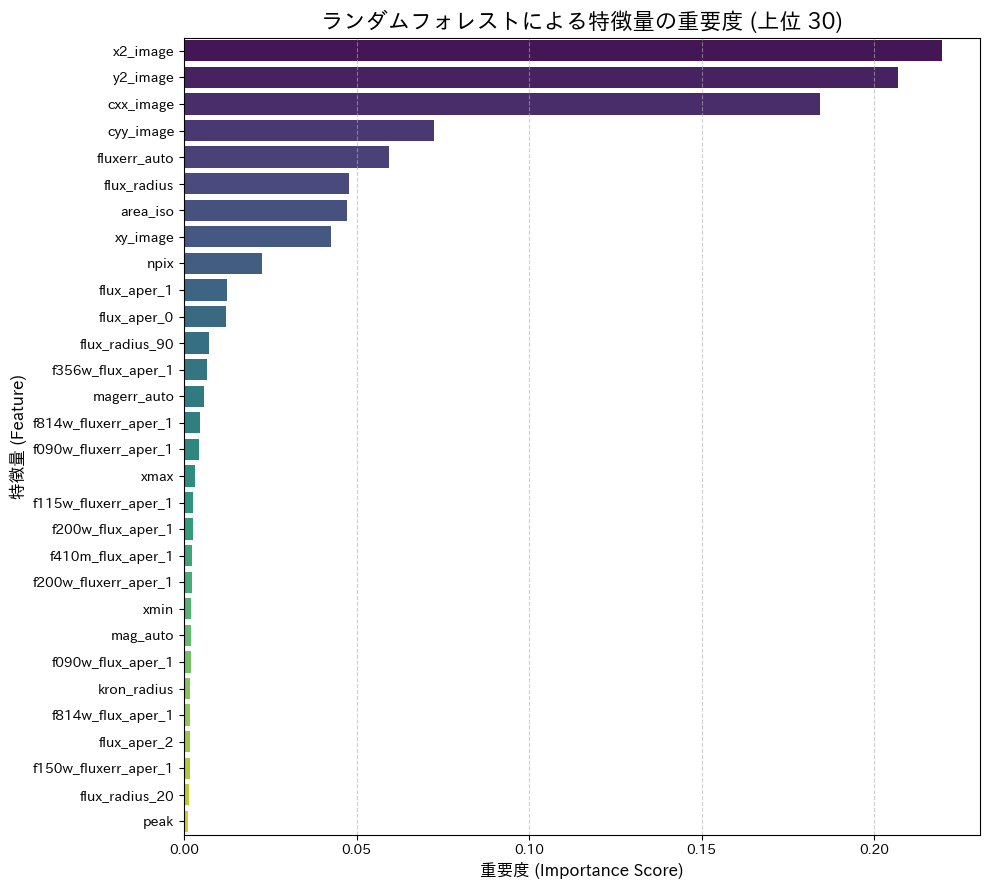

In [ ]:
from torch.utils.data import DataLoader
from custom_dataset import HDF5Dataset
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import pandas as pd
import japanize_matplotlib

# 特徴量として使用する列名
features = [
    # マグニチュードはフラックスと逆の関係にあるため、暗いオブジェクト（マグニチュードが大きい）ほど、area_auto が小さくなる傾向があるかもしれません。
    'mag_auto',
    'mag_iso',
    # アイソフォタル（等光度）アパーチャによる面積であり、オブジェクトのサイズを測る別の方法です。自動アパーチャによる面積と強い相関があると考えられます。
    'area_iso',
    # Kron 半径は、オブジェクトの光度分布に基づいて定義される半径で、オブジェクトのサイズを示す指標となります。Kron 半径が大きいほど、area_auto も大きくなる傾向があると考えられます。
    'kron_radius',
    # これはオブジェクトを構成するピクセルの数です。ピクセル数が多ければ多いほど、オブジェクトの面積も大きくなるため、area_auto と直接的な関係があると考えられます。
    'npix',
    'theta_image',
    'cxx_image',
    'cxy_image',
    'cyy_image',
    # これらのパラメータは、画像内でのオブジェクトの範囲を示す最大・最小の x, y 座標です。これらの値からオブジェクトのおおよその面積を推定できるため、area_auto と関連性が高いと考えられます。
    'xmax',
    'xmin',
    'ymax',
    'ymin',
    # これらのパラメータは、画像内のオブジェクトの形状とサイズに関する二次モーメントです。特に x2_image と y2_image は、オブジェクトの広がりを示すため、area_auto と関連する可能性があります。
    'x2_image',
    'y2_image',
    'xy_image',
    # 明るいオブジェクト（フラックスが大きい）ほど、自動検出アルゴリズムによってより広い範囲がオブジェクトとして認識される可能性があり、結果的に area_auto が大きくなることがあります。ただし、点源のようなコンパクトな明るいオブジェクトの場合はこの限りではありません。
    'flux_auto',
    'flux_iso',
    'flux_aper_0',
    'flux_aper_1',
    'flux_aper_2',
    # これらのパラメータは、オブジェクトの全フラックスの一定割合を含む半径を示します。これらの半径が大きいほど、オブジェクトが広がっている可能性があり、area_auto も大きくなる可能性があります。
    'flux_radius',
    'flux_radius_20',
    'flux_radius_90',
    'z_spec',
    'fluxerr_auto',
    'magerr_auto',
    'peak',
    'flux_aper_0',
    'fluxerr_aper_0',
    'flux_aper_1',
    'fluxerr_aper_1',
    'bkg_auto',
    'thresh',
    'flag_auto',
    'f070w_flux_aper_1',
    'f070w_fluxerr_aper_1',
    'f090w_flux_aper_1',
    'f090w_fluxerr_aper_1',
    'f115w_flux_aper_1',
    'f115w_fluxerr_aper_1',
    'f150w_flux_aper_1',
    'f150w_fluxerr_aper_1',
    'f200w_flux_aper_1',
    'f200w_fluxerr_aper_1',
    'f277w_flux_aper_1',
    'f277w_fluxerr_aper_1',
    'f356w_flux_aper_1',
    'f356w_fluxerr_aper_1',
    'f410m_flux_aper_1',
    'f410m_fluxerr_aper_1',
    'f444w_flux_aper_1',
    'f444w_fluxerr_aper_1',
    'f606w_flux_aper_1',
    'f606w_fluxerr_aper_1',
    'f814w_flux_aper_1',
    'f814w_fluxerr_aper_1',
]

# ターゲット変数 (予測したい変数)
target = 'area_auto'
dataset = HDF5Dataset("ceers.hdf5", features + [target], None)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
# Draw histogram
import matplotlib.pyplot as plt
import numpy as np
# DataLoader から 1 バッチ取得
for batch in dataloader:
    data = {key: batch[key].numpy() for key in features + [target]}
    break  # 最初のバッチのみ使用

# --- デバッグ: 各特徴量の形状を確認 ---
print("\n--- 各特徴量の形状チェック ---")
expected_shape = None
inconsistent_features = {}
for f in features:
    current_shape = data[f].shape
    if expected_shape is None:
        expected_shape = current_shape
        print(f"基準形状: {f} -> {expected_shape}")
    elif current_shape != expected_shape:
        print(f"形状不一致!: {f} -> {current_shape} (期待値: {expected_shape})")
        inconsistent_features[f] = current_shape

# ターゲット変数の形状も確認
target_shape = data[target].shape
print(f"ターゲット ({target}) の形状: {target_shape}")
if expected_shape is not None and target_shape[0] != expected_shape[0]: # 1次元配列と仮定して最初の次元(長さ)を比較
     print(f"警告: ターゲット ({target}) の長さ ({target_shape[0]}) が特徴量の期待される長さ ({expected_shape[0]}) と異なります。")

if inconsistent_features:
    print(f"\nエラーの原因となっている可能性のある特徴量: {list(inconsistent_features.keys())}")
    # --- ここで処理を中断するか、問題のある特徴量を除外する ---
    # 例: 問題のある特徴量を除外して続行する場合
    print("問題のある特徴量を除外して続行します。")
    features = [f for f in features if f not in inconsistent_features]
    if not features:
        print("エラー: 有効な特徴量が残っていません。")
        exit() # または適切なエラー処理
else:
    print("\n全ての特徴量の形状 (長さ) は一致しています。")


# --- ランダムフォレストによる特徴量重要度の計算 ---

# 特徴量 (X) とターゲット (y) を抽出
X = np.stack([data[f] for f in features], axis=1)
y = data[target]

print(f"特徴量データの形状 (X): {X.shape}")
print(f"ターゲットデータの形状 (y): {y.shape}")

# NaN/Inf のチェックと処理 (SimpleImputerを使用)
# 無限大をNaNに置換してから補完する
X = np.nan_to_num(X, nan=np.nan, posinf=np.nan, neginf=np.nan)
y = np.nan_to_num(y, nan=np.nan, posinf=np.nan, neginf=np.nan).ravel() # yも1次元配列にする

# NaNが含まれているか確認
if np.isnan(X).any() or np.isnan(y).any():
    print("NaNが含まれているため、平均値で補完します。")
    # XのNaNを列の平均値で補完
    imputer_x = SimpleImputer(strategy='mean')
    X = imputer_x.fit_transform(X)
    # yのNaNを全体の平均値で補完 (yは1次元なので strategy='mean' でOK)
    imputer_y = SimpleImputer(strategy='mean')
    # SimpleImputerは2D配列を期待するため、一時的にreshape
    y = imputer_y.fit_transform(y.reshape(-1, 1)).ravel()
else:
    print("NaNは検出されませんでした。")

# ランダムフォレスト回帰モデルのインスタンス化
# n_estimators: 木の数 (多いほど良いが計算時間増)
# max_depth: 木の深さの上限 (Noneだと制限なし)
# random_state: 再現性のためのシード
# n_jobs=-1: CPUコアをすべて使用して並列計算
rf_model = RandomForestRegressor(n_estimators=100,
                                 max_depth=None,    # 深さ制限なし (データに合わせて調整可)
                                 random_state=42,
                                 n_jobs=-1,
                                 oob_score=False) # OOBスコアは計算しない (今回は不要)

print("ランダムフォレストモデルの学習を開始...")
rf_model.fit(X, y)
print("学習完了。")

# 特徴量の重要度を取得
importances = rf_model.feature_importances_

# 重要度を特徴量名と紐付けて表示・ソート
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- 特徴量の重要度 (上位) ---")
print(feature_importance_df.head(20)) # 上位20個を表示

# --- 重要度の可視化 ---
top_n = 30 # 上位いくつの特徴量をプロットするか

plt.figure(figsize=(10, max(6, top_n * 0.3))) # プロット数に応じて高さを調整
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'ランダムフォレストによる特徴量の重要度 (上位 {top_n})', fontsize=16)
plt.xlabel('重要度 (Importance Score)', fontsize=12)
plt.ylabel('特徴量 (Feature)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()